 <h1 style="font-family:verdana;"> <center>BERT FINETUNING WITH ⚡PYTORCH LIGHTNING AND TRACKING THE "WEIGHTS AND BIASES(WANDB)" LOGS</center> </h1>

📌OTHER NOTEBOOKS FOR THE COMPETITION:
* [PyTorch Prompt-Tuning BERT](https://www.kaggle.com/shreyasajal/prompt-tuning-bert-commonlit-readability)  
* [Pytorch BERT BASELINE & LR SCHEDULERS' GUIDE](https://www.kaggle.com/shreyasajal/pytorch-bert-baseline-lr-schedulers-guide)  
* [PyTorch OpenAI GPT-2 FineTuning](https://www.kaggle.com/shreyasajal/pytorch-openai-gpt2-commonlit-readability)

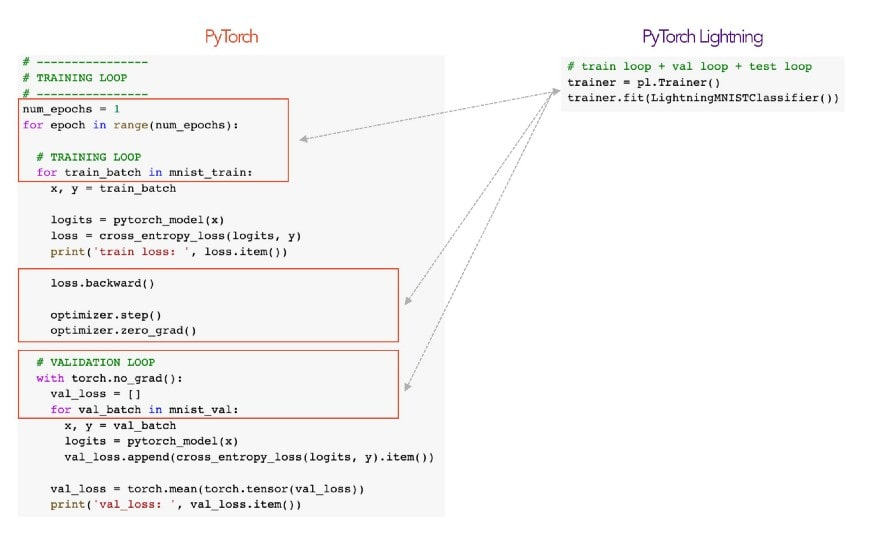

PyTorch Lightning is a PyTorch extension for the prototyping of the training, evaluation and testing phase of PyTorch models. Also, PyTorch Lightning provides a simple, friendly and intuitive structure to organize each component of the training phase of a PyTorch model. On the other hand, PyTorch Lightning provides a great variety of functionalities and flags for a detailed customization of the training of our model. In short, PyTorch Lightning came to organize, simplify and compact the components that involve a training phase of a deep learning model such as: training, evaluation, testing, metrics tracking, experiment organization and logs.


<p style="color:#159364; font-family:cursive;">INSTALL THE TRANSFORMERS PACKAGE FROM THE HUGGING FACE LIBRARY</center></p>


In [ ]:
!pip install transformers

<p style="color:#159364; font-family:cursive;">Installing PyTorch XLA Frameworks so that we can work with TPUs.</center></p>

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev

In [ ]:
!pip install --upgrade -q wandb

# Install timm 
!pip install -q timm

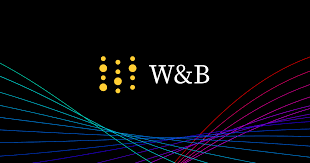

# IMPORT WANDB LOGGER
Coupled with Weights & Biases integration,we can quickly train and monitor models

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

# <p style="color:#159364; font-family:cursive;">IMPORT THE LIBRARIES</center></p>

In [ ]:
import os
import timm
import gc
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import pytorch_lightning as pl
import time
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

from transformers import BertTokenizer,BertForSequenceClassification, BertModel, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from collections import defaultdict

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import warnings
warnings.filterwarnings("ignore")


# <p style="color:#159364; font-family:cursive;">LOOK AT THE DATA</center></p>

In [ ]:
df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv",usecols=["id","excerpt"])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

# <p style="color:#159364; font-family:cursive;">A BIT OF PREPROCESSING</center></p>

In [ ]:
def prep_text(text_df):
    text_df = text_df.str.replace("\n","",regex=False) 
    return text_df.str.replace("\'s",r"s",regex=True).values
df["excerpt"] = prep_text(df["excerpt"])
test_df["excerpt"] = prep_text(test_df["excerpt"])

# <p style="color:#159364; font-family:cursive;">CREATE FOLDS</center></p>

Code taken from:https://www.kaggle.com/abhishek/step-1-create-folds

In [ ]:
def create_folds(data, num_splits):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins"] = pd.cut(
        data["target"], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = StratifiedKFold(n_splits=num_splits)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data


# create folds
df = create_folds(df, num_splits=5)

# <p style="color:#159364; font-family:cursive;">TRAINING CONFIGURATION</center></p>

In [ ]:
class CONFIG:
    seed = 42
    max_len = 331
    train_batch = 16
    valid_batch = 32
    epochs = 10
    learning_rate = 2e-5
    splits = 5
    model='bert-base-cased'
    tokenizer = BertTokenizer.from_pretrained(model, do_lower_case=True)
    tokenizer.save_pretrained('./tokenizer')
    accum=1
    

# <p style="color:#159364; font-family:cursive;">REPRODUCIBILITY</center></p>

In [ ]:
def set_seed(seed = CONFIG.seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG.seed)

# <p style="color:#159364; font-family:cursive;">DEFINE THE DATASET CLASS</center></p>

In [ ]:
class BERTDataset(Dataset):
    def __init__(self,df):
        self.text = df['excerpt'].values
        self.target = df['target'].values
        self.max_len = CONFIG.max_len
        self.tokenizer = CONFIG.tokenizer
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = self.text[index]
        text = ' '.join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )

        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            'label': torch.tensor(self.target[index], dtype=torch.float)
        }

In [ ]:
def get_data(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = BERTDataset(df_train)
    valid_dataset = BERTDataset(df_valid)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch, 
                              num_workers=4, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [ ]:
def loss_fn(output,target):
     return torch.sqrt(nn.MSELoss()(output,target))

# <p style="color:#159364; font-family:cursive;">MODEL CLASS </center></p>
It is important to note that we are not extending from “nn.Module” as we would commonly do in a pure PyTorch model, in this case we are extending from “pl.LightningModule”.

In [ ]:
class Model(pl.LightningModule):

    def __init__(self,fold):
        super(Model, self).__init__()
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1,output_attentions = False,output_hidden_states = False)
        self.model = model
        train_dataloader, val_dataloader= get_data(fold)
        self._train_dataloader = train_dataloader
        self._val_dataloader = val_dataloader
        self.all_targets=[]
        self.all_preds=[]
        self.automatic_optimization = True
        
    def configure_optimizers(self):
        param_optimizer = list(self.model.named_parameters())
        no_decay = ["bias", "gamma", "beta"]
        optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                    "weight_decay_rate": 0.01
                    },
                {
                    "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                    "weight_decay_rate": 0.0
                    },
                ]
        optimizer = AdamW(
                optimizer_grouped_parameters,
                lr=CONFIG.learning_rate,
                )
        
        # Defining LR Scheduler
        scheduler = get_linear_schedule_with_warmup( optimizer, 
        num_warmup_steps=0, 
        num_training_steps=len(self._train_dataloader )*CONFIG.epochs)
        self.scheduler=scheduler
        self.optimizer=optimizer
        return {
            'optimizer': self.optimizer,
            'lr_scheduler': {
                'scheduler': self.scheduler,
                'monitor': 'val_loss',
            }
        }

    def training_step(self, batch, batch_idx):
        labels = batch["label"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        token_type_ids = batch["token_type_ids"]
        
        loss= self.model(
                input_ids,
                attention_mask=attention_mask
                )
        output=loss['logits']
        loss=loss_fn(output,labels)
        self.train_loss +=(loss.item() * len(labels))
        self.t_data_size+=len(labels)
        epoch_loss=self.train_loss/self.t_data_size
        self.log('train_loss', epoch_loss, on_epoch=True, prog_bar=True, logger=True)
        tqdm_dict={'train_loss':loss}
        sch=self.scheduler
        sch.step()
        output = OrderedDict({
            "loss": loss,
            "progress_bar": tqdm_dict,
            "log": tqdm_dict
            })

        return output
        
    def validation_step(self, batch, batch_idx):
        labels = batch["label"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        token_type_ids = batch["token_type_ids"]
        loss= self.model(
                input_ids,
                attention_mask=attention_mask
                )
        outputs=loss['logits']
        loss=loss_fn(outputs,labels)
        self.val_loss +=(loss.item() * len(labels))
        self.v_data_size+=len(labels)
        epoch_loss=self.val_loss/self.v_data_size
        self.all_targets.extend(labels.detach().squeeze(-1).cpu().numpy())
        self.all_preds.extend(outputs.detach().squeeze(-1).cpu().numpy())
        val_rmse = mean_squared_error(self.all_targets,self.all_preds,squared=False)
        
        logs = {
                "val_loss": epoch_loss,
                "val_rmse": val_rmse,
                }
        self.log_dict(logs, on_epoch=True, prog_bar=True, logger=True)
        output = OrderedDict({
            "val_loss": loss,
            "preds":self.all_preds,
            "labels":self.all_targets,
            "batch_size": len(labels)
            })
        return output

    def validation_end(self, outputs):
        val_loss = sum([out["val_loss"] for out in outputs]) / len(outputs)
        result = {"progress_bar": tqdm_dict, "log": tqdm_dict, "val_loss": val_loss}
        return result
   
    def train_dataloader(self):
        return self._train_dataloader

    def val_dataloader(self):
        return self._val_dataloader


So far everything is normal, the previous steps we would also have done if we were to train a pure PyTorch model. The big difference comes next,when we initialize our model, as we can see, we are only passing the fold as a parameter.The “Trainer” of PyTorch Lightning is the key piece for the training. We can pass a large number of arguments to the “Trainer” in order to have a detailed customization of our training phase, in this case we are only defining the maximum number of epochs,logger,callbacks and tpu_cores

# <p style="color:#159364; font-family:cursive;">CALLBACKS</center></p>
* A callback is a piece of code that you’d like to be executed at various parts of training. In Lightning callbacks are reserved for non-essential code such as logging or something not related to research code. This keeps the research code super clean and organized.

In [ ]:
lr_monitor = LearningRateMonitor(logging_interval='step')
# Checkpoint
checkpoint_callback = ModelCheckpoint(monitor='val_rmse',
                                      save_top_k=1,
                                      save_last=True,
                                      save_weights_only=True,
                                      filename='checkpoint/{epoch:02d}-{val_loss:.4f}',
                                      verbose=False,
                                      mode='min')

# Earlystopping
earlystopping = EarlyStopping(monitor='val_rmse', patience=5, mode='min')

# <p style="color:#159364; font-family:cursive;">RUN THE MODEL WITH PYTORCH LIGHTNING TRAINER and EVALUATE IT WITH WANDB</center></p>
* In Lightning, you can train your model on CPUs, GPUs, Multiple GPUs, or TPUs without changing a single line of your PyTorch code.
* no TPU specific code
* no .to(device)
* no .cuda()
* Just 1 argument in the trainer,and the rest is automated 

In [ ]:
#fold1 train
model = Model(1)
# instrument experiment with W&B
wandb_logger = WandbLogger(project='CommonlitReadabilityTrain_', log_model='all',job_type='train')
trainer = pl.Trainer(logger=wandb_logger,max_epochs=CONFIG.epochs,accumulate_grad_batches=CONFIG.accum,callbacks=[earlystopping,lr_monitor],checkpoint_callback =checkpoint_callback ,tpu_cores=1)
# log gradients and model topology
wandb_logger.watch(model)
trainer.fit(model)
wandb.finish()


# TRACK YOUR EXPERIMENTS

## LOSSES
    
![img](https://imgur.com/sgLd13Z.gif)


## LEARNING RATE
![img](https://imgur.com/a4DbLom.gif)


## SYSTEM LOGS
![img](https://imgur.com/MEO8vRm.gif)


![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)
